# AgPV Index
Exploratory data analysis for creation of an AG PV index: a composite scoring metric to identify USA counties with high cobenefits potential for agrivoltaics

* Data inputs: solar supply, weather hazards, energy burden, minority owned cropland

## Data Processing
Things to do:

* aggregate NREL's solar supply data by county
* get relevant weather hazards data from csv file (hail and drought are positives, tornado is negative.)
    * might start ith overall agriculture burden for positives first
* load energy burden data
* get minoirty owned data from R2R indices to start

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

### Solar Supply Data NREL

Commonly cited NREL data for solar supply. I'm aggregating this by county.

https://www.nrel.gov/gis/solar-resource-maps.html

In [2]:
# got solar supply data
solar_dir = 'solar-pv-reference-access-2023'
solar_file = 'reference_access_2030_moderate_supply-curve.csv'

solar_df = pd.read_csv(os.path.join(solar_dir, solar_file), dtype={'cnty_fips':str})
solar_df['cnty_fips'] = solar_df['cnty_fips'].apply(lambda x: x.zfill(5))

# get total for each county
location_cols = ['cnty_fips', 'county', 'state']
solar_sums_df = solar_df.groupby(location_cols, as_index=False).sum()

# I think we just need capacity_mw_ac
solar_sums_df = solar_sums_df[location_cols + ['capacity_mw_ac', 'capacity_mw_dc']]

# rename fips column
solar_sums_df = solar_sums_df.rename(columns={'cnty_fips':'FIPS'})
solar_sums_df.head()

FIPS   county    state  capacity_mw_ac  capacity_mw_dc
0  01001  Autauga  Alabama    22349.202978    29947.935193
1  01003  Baldwin  Alabama    46948.973155    62911.632997
2  01005  Barbour  Alabama    43344.657028    58081.848135
3  01007     Bibb  Alabama    28368.690972    38014.050777
4  01009   Blount  Alabama    18483.385380    24767.738851

### NRI Weather hazards data

FEMA has created weather hazard index scores for various weather hazards. Right now, I'm only focusing on how these hazards affect agricultural losses. For AgPV, tornadoes are negative, since they destroy solar panels. Drought, hail, and heatwave are positives, since AgPV can help protect crops or diversify farmer income hagainst these hazards.

Relevant columns:

* TRND_ALRA: expected tornado ag loss rate
* HWAV_ALRA: heatwave expected ag loss rate
* HAIL_ALRA: hail expected ag loss rate
* DRGT_ALRA: drought expected loss
* RESL_SCORE: community resilience score
* SOVI_SCORE: sovial vulnerability score

can use different suffixes for different metrics. Other metrics of interest:
* RISKV: risk value
* RISKS: risk index score
* RISKR: risk index rating

https://hazards.fema.gov/nri

In [3]:
data_dir = 'AgPV_data'
nri_dir = 'NRI_Table_Counties'
nri_file = 'NRI_Table_Counties.csv'

nri_df = pd.read_csv(os.path.join(data_dir, nri_dir, nri_file), dtype={'STCOFIPS':str})

# keep relevant columns
prefixes = ['TRND', 'HWAV', 'HAIL', 'DRGT']
suffixes = ['ALRA', 'RISKV', 'RISKS']
nri_keep_cols = ['_'.join([pf, sf]) for pf in prefixes for sf in suffixes]

nri_df = nri_df[['STCOFIPS', 'RESL_SCORE', 'SOVI_SCORE'] + nri_keep_cols]

# rename relevant columns
nri_df = nri_df.rename(columns={'STCOFIPS':'FIPS'})
nri_df.head()

FIPS  RESL_SCORE  SOVI_SCORE  TRND_ALRA    TRND_RISKV  TRND_RISKS  \
0  01001   51.810001   51.299999   0.000029  2.831745e+06   73.846643   
1  01003   86.120003   31.030001   0.000004  7.982720e+06   91.377665   
2  01005    6.240000   99.269997   0.000009  2.845056e+06   73.942094   
3  01007   19.730000   80.779999   0.000067  2.609927e+06   71.969456   
4  01009   22.820000   51.369999   0.000077  6.930682e+06   89.723194   

      HWAV_ALRA    HWAV_RISKV  HWAV_RISKS     HAIL_ALRA     HAIL_RISKV  \
0  2.747418e-06  8.799794e+05   87.082405  4.687348e-05  152041.957165   
1  9.080529e-07  1.243722e+06   91.091314  2.308179e-07  124028.950214   
2  2.747418e-06  2.821581e+05   69.710468  4.524451e-06   68324.832750   
3  4.200027e-06  2.428259e+05   67.228762  2.179460e-04   81868.702495   
4  4.200027e-06  6.368582e+05   82.437162  1.966831e-05   82093.176164   

   HAIL_RISKS  DRGT_ALRA     DRGT_RISKV  DRGT_RISKS  
0   57.111040   0.000826   28542.388900   50.652243  
1   52.943048   0.003216  484573.697842   86.796055  
2   39.993637   0.001623  295053.353506   80.687241  
3   43.684378   0.000831    4764.186212   32.421254  
4   43.716195   0.000093   32581.621879   52.147630

### Energy Burden

Percent of household income spent on energy. AgPV can help high burden counties lower their energy burden.

https://www.energy.gov/scep/slsc/lead-tool

In [4]:
eburden_file = 'LEAD Tool Data Counties.csv'

eburden_df = pd.read_csv(os.path.join(data_dir, eburden_file), skiprows=range(0,8), dtype={'Geography ID':str})
eburden_df = eburden_df.rename(columns={'Geography ID':'FIPS'})
eburden_df = eburden_df[['FIPS', 'Energy Burden (% income)']]
eburden_df.head()

FIPS  Energy Burden (% income)
0  01001                         3
1  01003                         2
2  01005                         4
3  01007                         4
4  01009                         3

### R2R Data

Farmer income and % of minority owned cropland analyzed for Roads to Removal. Don't get too sad at the minority owned farm numbers.

In [5]:
farm_income_file = 'avg_farm_income.csv'

# 'Avg Farm Net Income ($)' has a bunch of wierd str values. '(D)' is undisclosed, and this messes up pandas reading it as a float
farm_income_df = pd.read_csv(os.path.join(data_dir, farm_income_file), dtype={'County ANSI':str, 'State ANSI':str, 'Avg Farm Net Income ($)':str})
farm_income_df['FIPS'] = farm_income_df.apply(lambda x: x['State ANSI'].zfill(2) + x['County ANSI'].zfill(3), axis=1)
farm_income_df = farm_income_df[['FIPS', 'Avg Farm Net Income ($)']]
farm_income_df.head()

FIPS Avg Farm Net Income ($)
0  01001                  18,279
1  01011                  71,850
2  01047                  35,071
3  01051                   9,847
4  01063                  19,870

In [6]:
# minority owned cropland
minority_crop_file = 'minority_owned_cropland_counties.csv'

min_crop_df = pd.read_csv(os.path.join(data_dir, minority_crop_file), dtype={'fips_code':str})
min_crop_df = min_crop_df.rename(columns={'fips_code':'FIPS'})
min_crop_df = min_crop_df[['FIPS', 'Percent Minority Owned']]
min_crop_df.head()

FIPS  Percent Minority Owned
0  01005                0.000000
1  01011                1.984635
2  01013                0.000000
3  01025                0.000000
4  01043                0.415887

## Merge all DFs together

In [7]:
all_dfs = [solar_sums_df, nri_df, eburden_df, farm_income_df, min_crop_df]
all_dfs = [df.set_index('FIPS') for df in all_dfs]
merged_df = pd.concat(all_dfs, axis=1)
merged_df = merged_df.dropna(subset=['county'])

# percent minority owned has lots of missing data (due to a lack of minority owned cropland!) This means NaNs are effectivey 0
merged_df['Percent Minority Owned'] = merged_df['Percent Minority Owned'].fillna(0)

# clean farm income data. This column is the messiest
def clean_farm_income(x):
    if isinstance(x, float):
        return x
    
    if x.strip() == '(D)':
        return np.nan
    
    else:
        return float(x.replace(',', ''))
    
def fill_na_max(ser: pd.Series):
    return ser.fillna(ser.max())
            
merged_df['Avg Farm Net Income ($)'] = merged_df['Avg Farm Net Income ($)'].apply(clean_farm_income)

# fill undefined rows (nan entries) with max value. This is most conservative estimate
merged_df['Avg Farm Net Income ($)'] = fill_na_max(merged_df['Avg Farm Net Income ($)'])

# identify counties with negative net income
merged_df['Negative Net Farm Income'] = merged_df['Avg Farm Net Income ($)'].apply(lambda x: 1 if x < 0 else 0)

merged_df

county    state  capacity_mw_ac  capacity_mw_dc  RESL_SCORE  \
FIPS                                                                     
01001     Autauga  Alabama    22349.202978    29947.935193   51.810001   
01003     Baldwin  Alabama    46948.973155    62911.632997   86.120003   
01005     Barbour  Alabama    43344.657028    58081.848135    6.240000   
01007        Bibb  Alabama    28368.690972    38014.050777   19.730000   
01009      Blount  Alabama    18483.385380    24767.738851   22.820000   
...           ...      ...             ...             ...         ...   
56037  Sweetwater  Wyoming   401041.398994   537395.558058   30.709999   
56039       Teton  Wyoming     4915.661374     6586.986832   39.529999   
56041       Uinta  Wyoming    83816.558073   112314.202527   27.820000   
56043    Washakie  Wyoming    72277.627225    96852.034274   62.029999   
56045      Weston  Wyoming   155044.608219   207759.812413    9.740000   

       SOVI_SCORE  TRND_ALRA    TRND_RISKV  TRND_RISKS     HWAV_ALRA  ...  \
FIPS                                                                  ...   
01001   51.299999   0.000029  2.831745e+06   73.846643  2.747418e-06  ...   
01003   31.030001   0.000004  7.982720e+06   91.377665  9.080529e-07  ...   
01005   99.269997   0.000009  2.845056e+06   73.942094  2.747418e-06  ...   
01007   80.779999   0.000067  2.609927e+06   71.969456  4.200027e-06  ...   
01009   51.369999   0.000077  6.930682e+06   89.723194  4.200027e-06  ...   
...           ...        ...           ...         ...           ...  ...   
56037   37.400002   0.000002  6.773591e+04   10.531339  0.000000e+00  ...   
56039   19.190001   0.000015  2.501826e+05   21.189946  0.000000e+00  ...   
56041   40.639999   0.000002  9.517126e+04   12.567611  0.000000e+00  ...   
56043   26.610001   0.000009  1.060502e+05   13.013045  0.000000e+00  ...   
56045   23.200001   0.000037  3.330118e+05   24.657970  0.000000e+00  ...   

          HAIL_ALRA     HAIL_RISKV  HAIL_RISKS  DRGT_ALRA     DRGT_RISKV  \
FIPS                                                                       
01001  4.687348e-05  152041.957165   57.111040   0.000826   28542.388900   
01003  2.308179e-07  124028.950214   52.943048   0.003216  484573.697842   
01005  4.524451e-06   68324.832750   39.993637   0.001623  295053.353506   
01007  2.179460e-04   81868.702495   43.684378   0.000831    4764.186212   
01009  1.966831e-05   82093.176164   43.716195   0.000093   32581.621879   
...             ...            ...         ...        ...            ...   
56037  3.438775e-06    2120.127461    3.340757   0.000181    3696.294806   
56039  3.358620e-05   66342.791859   39.102768   0.000056    1075.132966   
56041  1.348420e-05   20153.573683   17.817372   0.000072    2228.192720   
56043  2.144430e-05    3930.810604    5.058861   0.000270   14587.599627   
56045  1.387603e-05  387196.905020   76.073815   0.000010     506.872120   

       DRGT_RISKS  Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                                   
01001   50.652243                       3.0                  18279.0   
01003   86.796055                       2.0                  35436.0   
01005   80.687241                       4.0                  63011.0   
01007   32.421254                       4.0                  -1650.0   
01009   52.147630                       3.0                  66897.0   
...           ...                       ...                      ...   
56037   29.812281                       2.0                  21628.0   
56039   21.539930                       2.0                   6411.0   
56041   25.676106                       3.0                  10310.0   
56043   43.143493                       4.0                  28058.0   
56045   19.153675                       7.0                  15943.0   

       Percent Minority Owned  Negative Net Farm Income  
FIPS                                                     
0100

## Data Exploration
Are there strong correlations in the undrelying variables> That might skew results.

Ac and DC solar potential are nearly identical and strongly correlated, so we can just use one of them.

Other than that, I didn't see any strong correlations between the variables. There is some positive correlation (~0.5) between tornado risk and the other weather hazards.

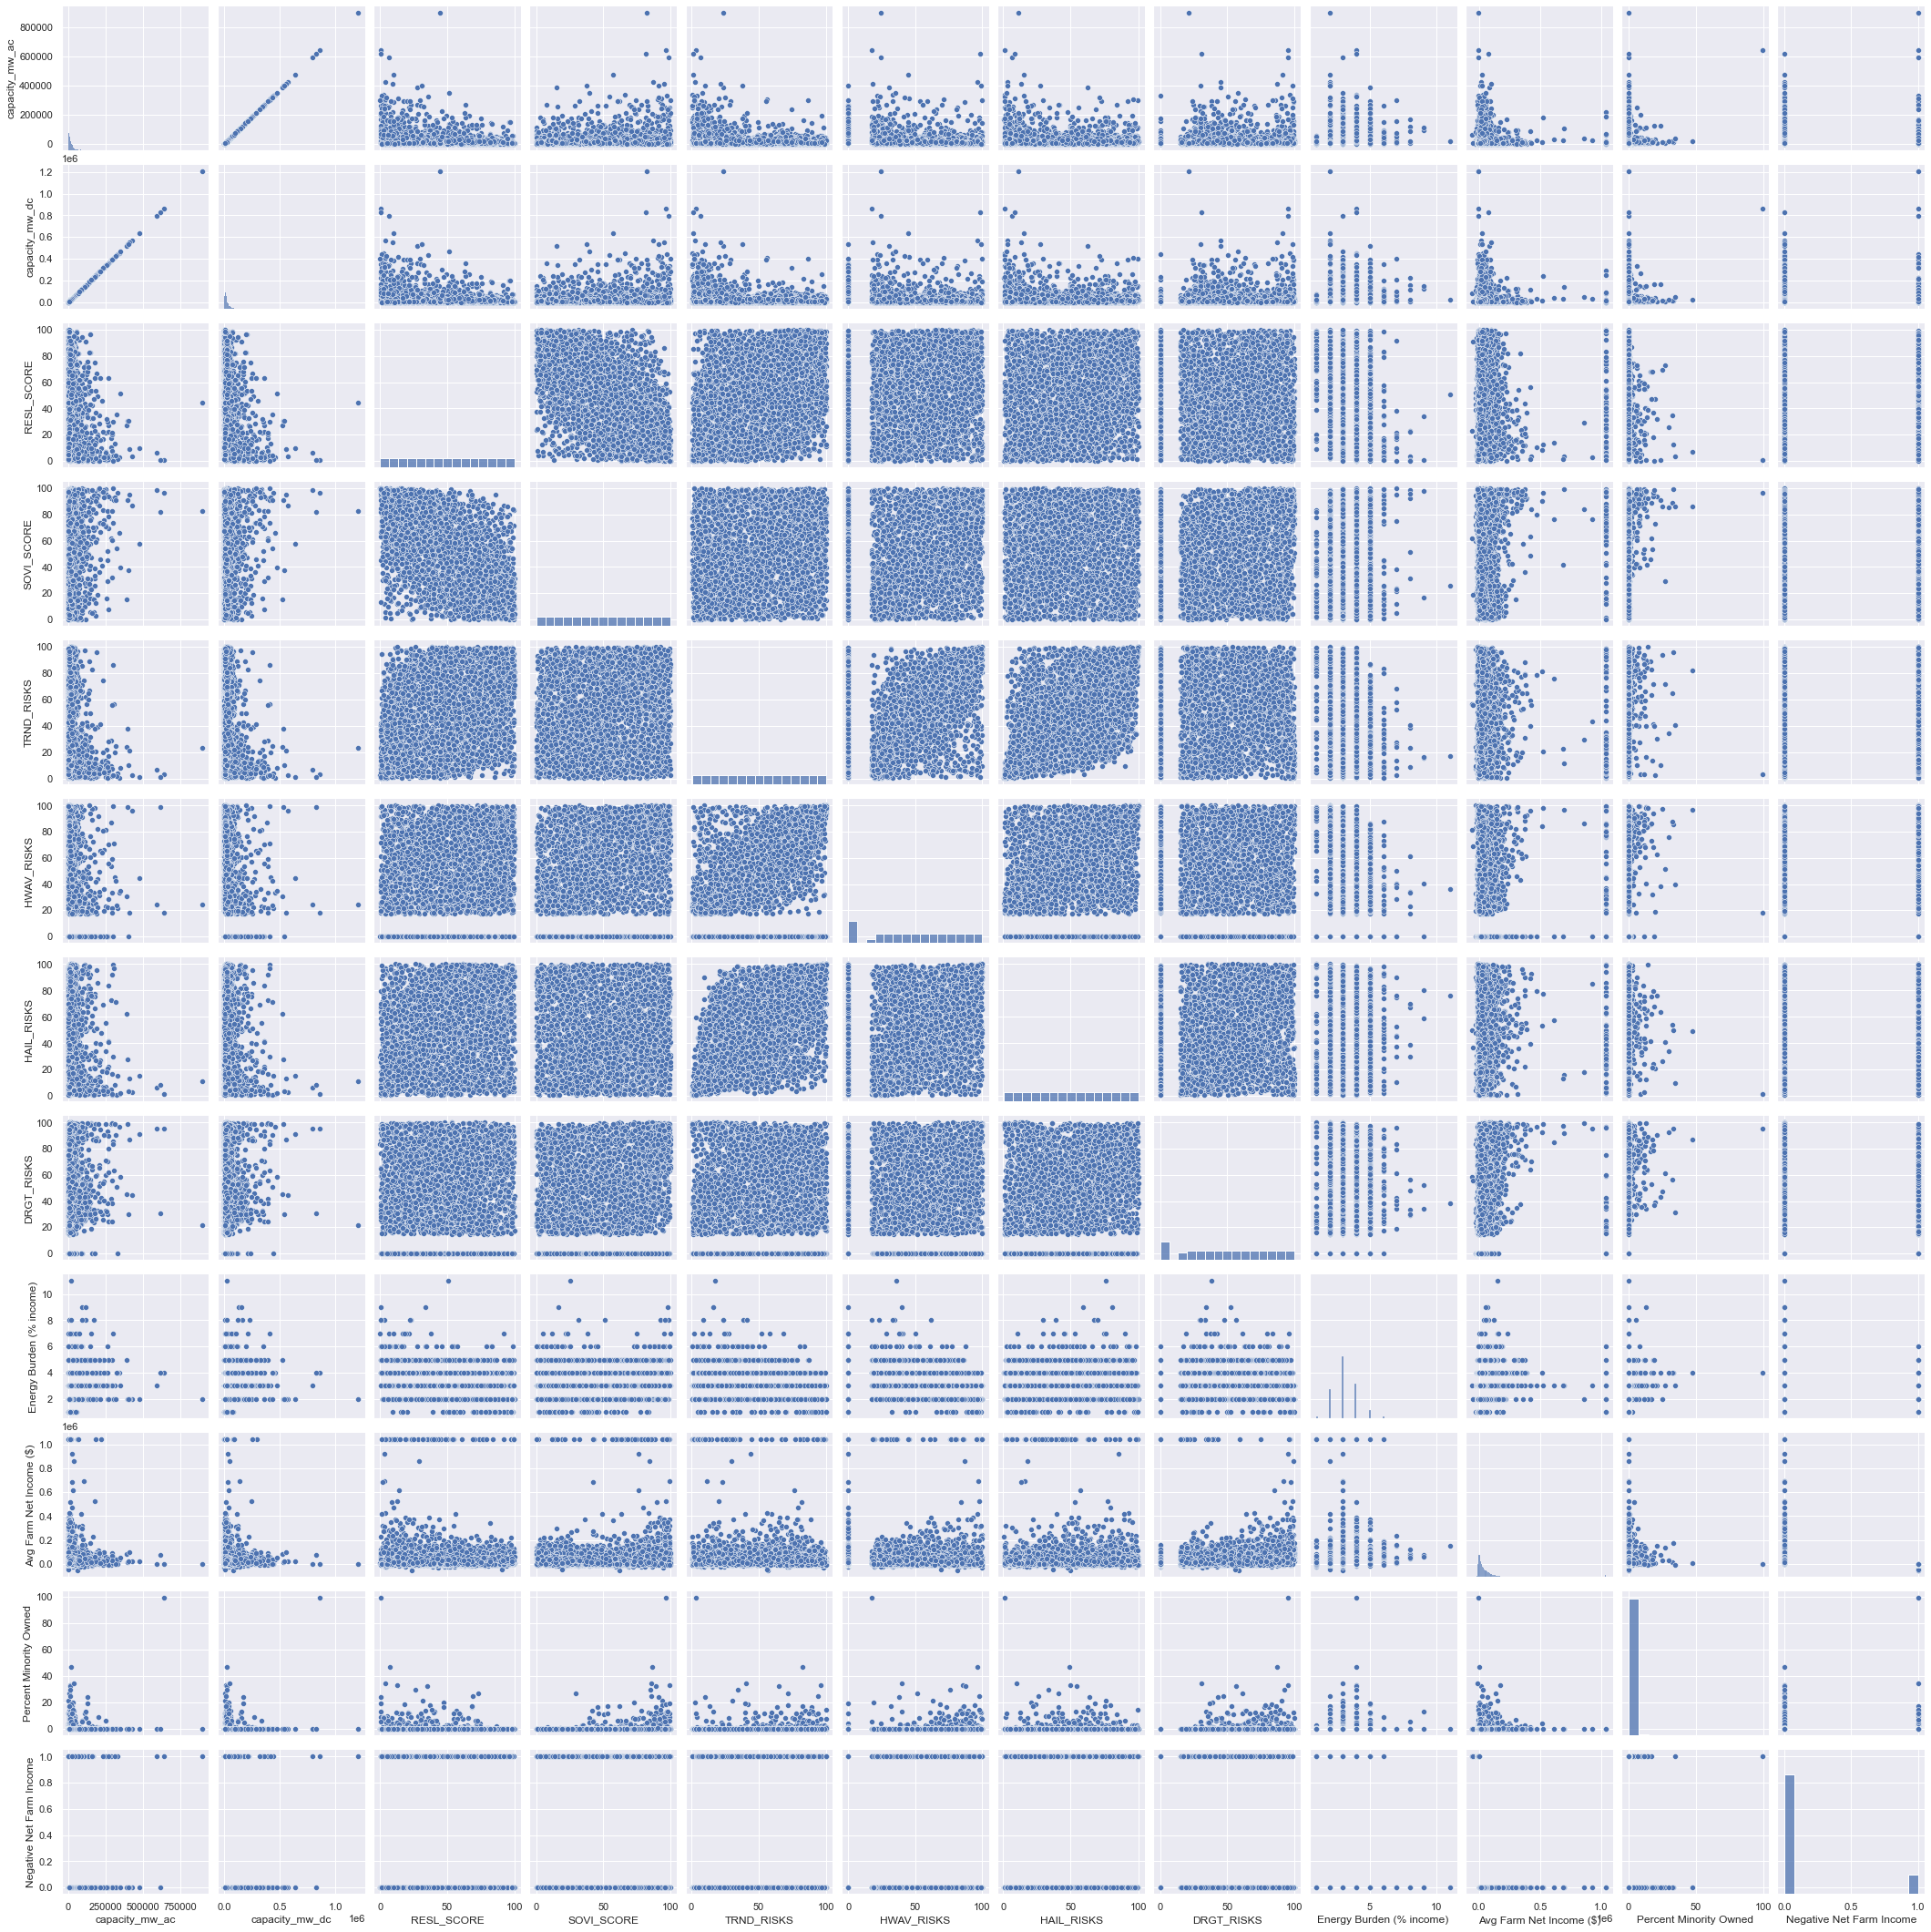

In [8]:
# only use one set of nri metric to make the graph comprehensible
sns.set_theme(style='darkgrid')
plot_cols = [col for col in merged_df.columns if '_RISKV' not in col and '_ALRA' not in col]
sns.pairplot(merged_df[plot_cols])

# save plot
graph_dir = 'AgPV_graphs'
graph_file = 'agpv_pairplot.png'
plt.savefig(os.path.join(graph_dir, graph_file))

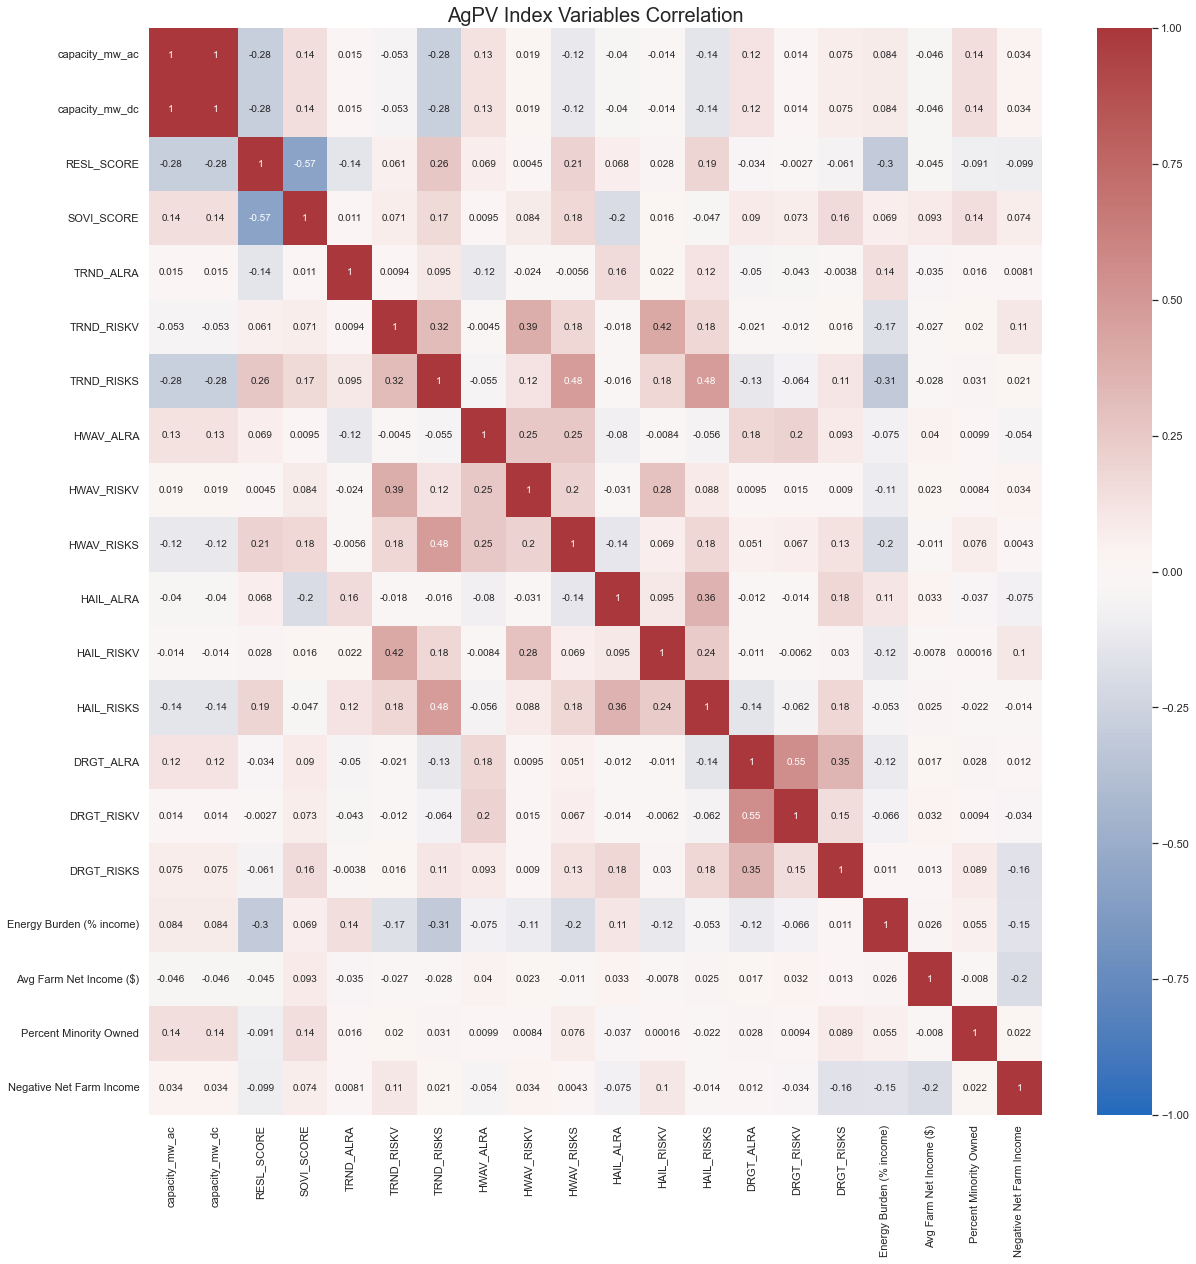

In [9]:
fig, ax = plt.subplots(figsize=(20,20))
corr_df = merged_df.iloc[:, 2:].corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Correlation', size=20)

# save file
corr_file = 'agpv_corr.png'
plt.savefig(os.path.join(graph_dir, corr_file))

## Index Preprocessing

NRI score values seem appropriate over using the value or expected loss metric since SVI and community resiliency also use score.

For roads to removal, I used a Box-Cox transform to try and fit to a normal distribution. This time, I'm trying quantile normalization, which really forces the data to a normal distribution. The results look much more gaussian. In a sense, it's mangling the data, but since we're already doing so much to it anyway with the scaling, it's probably OK. In most cases, we get very pretty bell curves.

Process:

* Transform underlying variables to fit normal dist'n
* Minmax scale data [0-1]
* Invert 'negative' variables (tornadoes and farmer income)
* Average values of underlying variables
* Minmax scal results [0-1]

In [10]:
# use quantile normalization to make everything have a normal distribution
from sklearn.preprocessing import quantile_transform, MinMaxScaler
X = quantile_transform(merged_df[plot_cols].iloc[:, 2:], output_distribution='normal')

# scale all values 0-1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# create df from transformed data
normalized_df = pd.DataFrame(X, columns=merged_df[plot_cols].iloc[:, 2:].columns, index=merged_df.index)
normalized_df = normalized_df.drop(columns=['capacity_mw_dc', 'Negative Net Farm Income'])

# need to invert the neagtives in the index: tornado risk and farm income
normalized_df['Avg Farm Net Income ($)'] = 1 - normalized_df['Avg Farm Net Income ($)']
normalized_df['TRND_RISKS'] = 1 - normalized_df['TRND_RISKS']
normalized_df.head()

capacity_mw_ac  RESL_SCORE  SOVI_SCORE  TRND_RISKS  HWAV_RISKS  \
FIPS                                                                    
01001        0.547606    0.504096    0.503589    0.440039    0.607810   
01003        0.612906    0.603788    0.453189    0.369846    0.628607   
01005        0.606443    0.352327    0.735681    0.439753    0.548137   
01007        0.570571    0.418034    0.584009    0.445549    0.541421   
01009        0.530352    0.428265    0.503724    0.379363    0.588573   

       HAIL_RISKS  DRGT_RISKS  Energy Burden (% income)  \
FIPS                                                      
01001    0.515519    0.499335                  0.488268   
01003    0.505205    0.606212                  0.387543   
01005    0.473010    0.581966                  0.580867   
01007    0.482337    0.452925                  0.580867   
01009    0.482416    0.503013                  0.488268   

       Avg Farm Net Income ($)  Percent Minority Owned  
FIPS                                                    
01001                 0.524196                     0.0  
01003                 0.487156                     0.0  
01005                 0.445676                     0.0  
01007                 0.617746                     0.0  
01009                 0.439937                     0.0

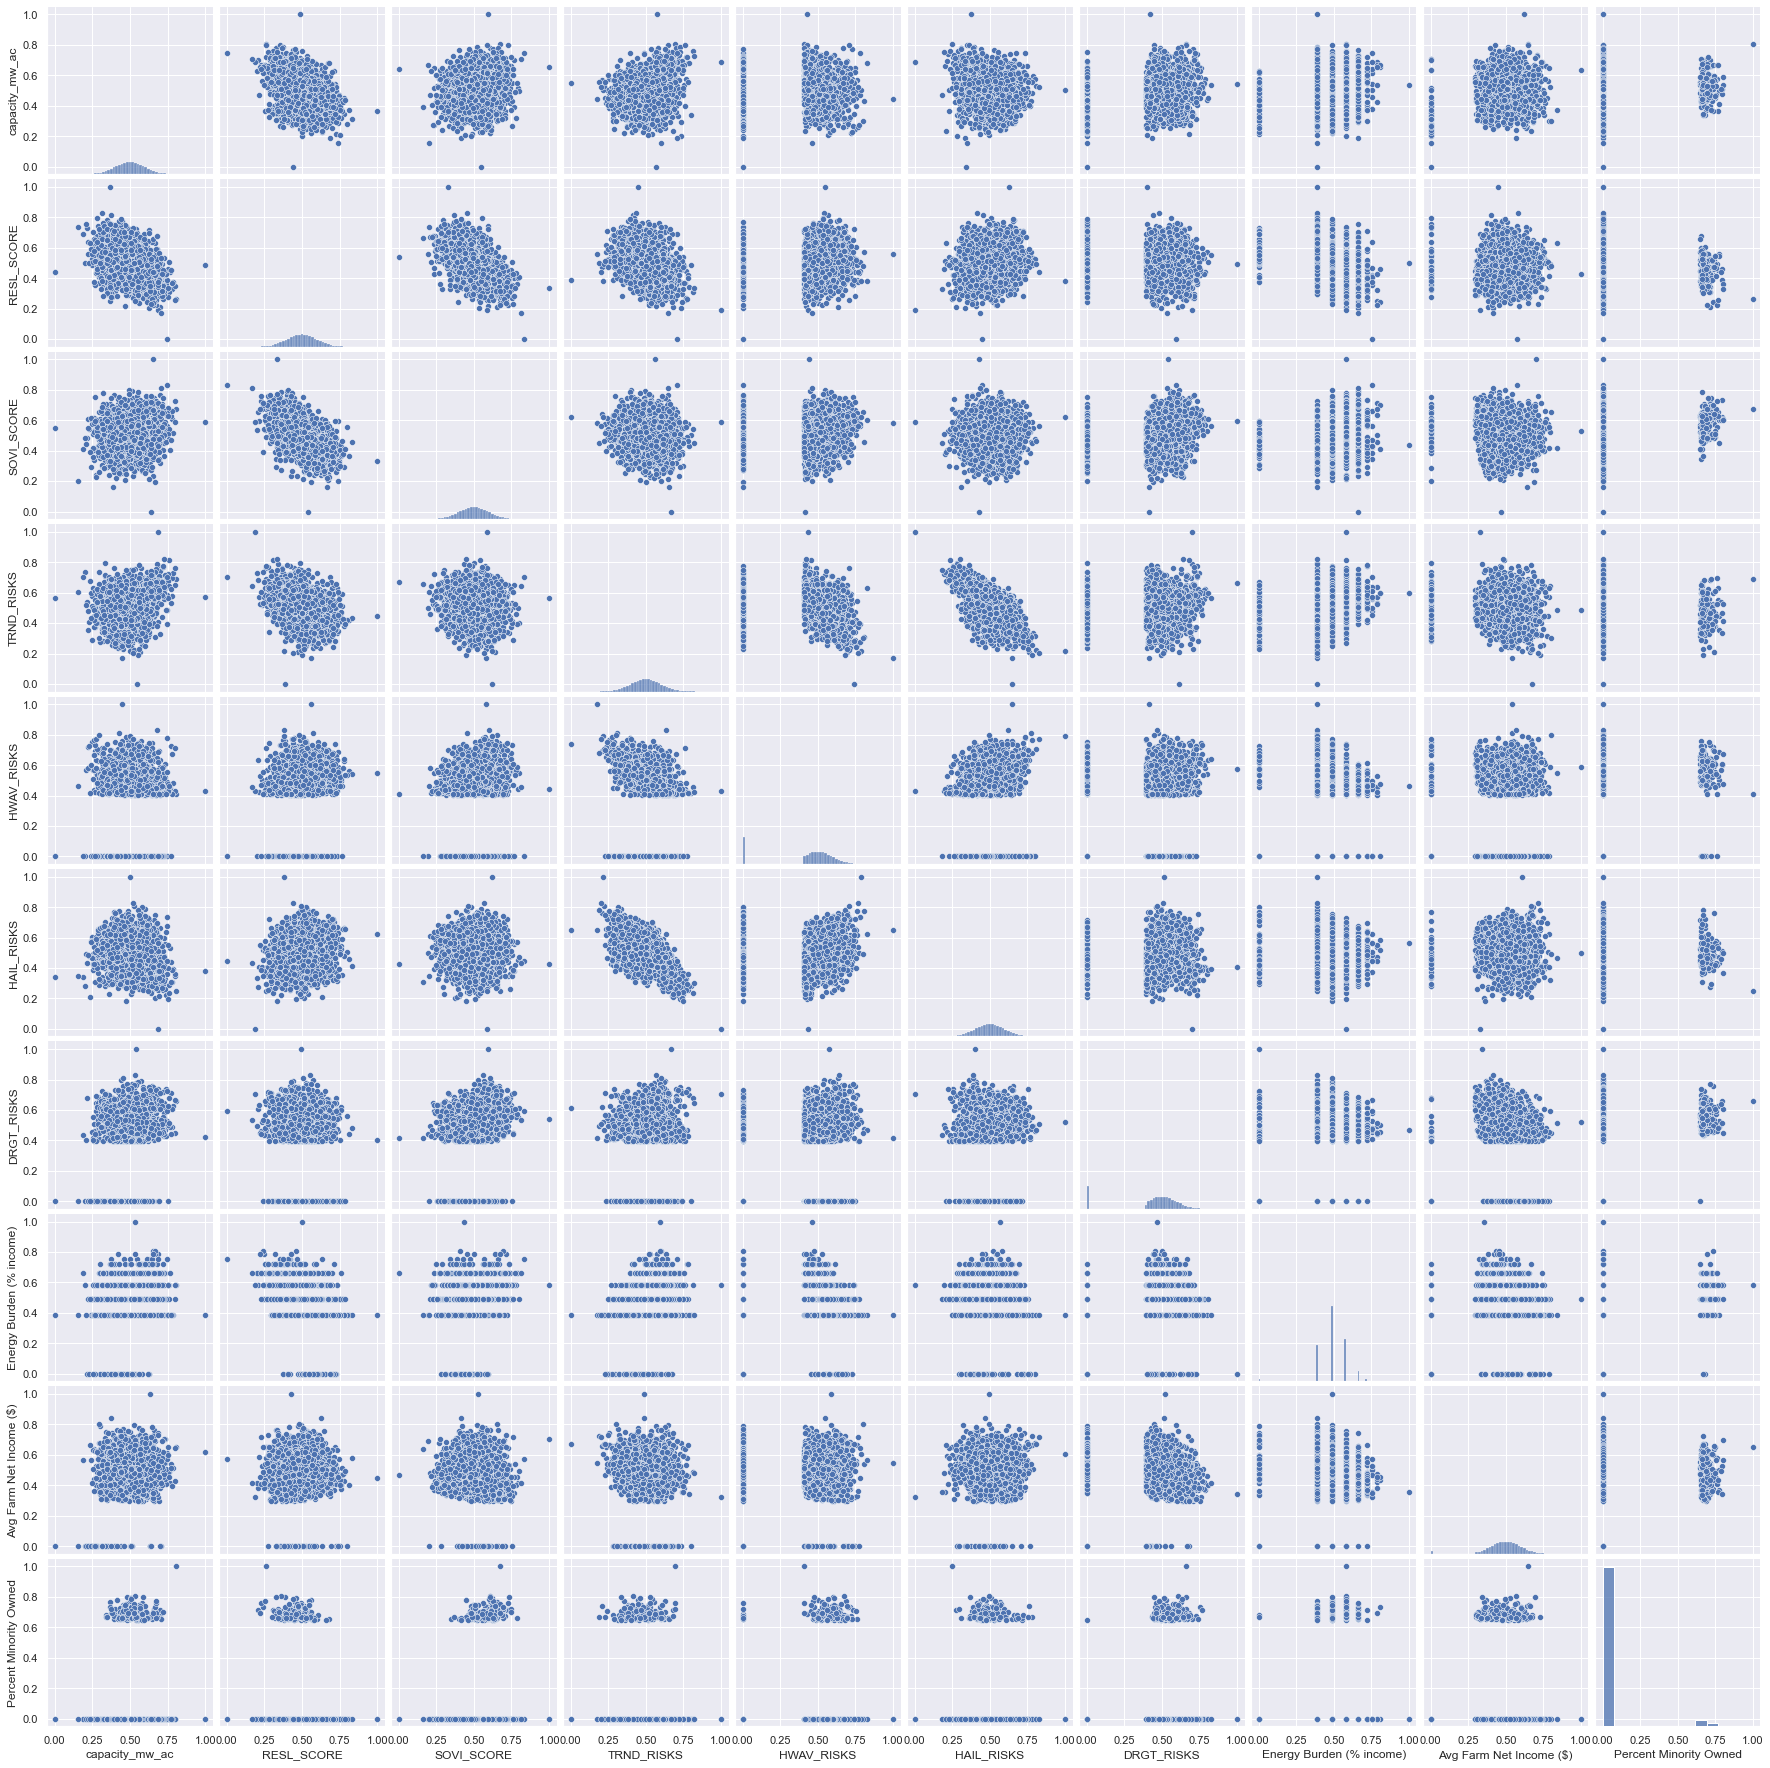

In [11]:
sns.pairplot(normalized_df)

The transformations seemed to slightly exxagerate correlation between toranado and hail risk. Tornado and energy burden also have some correlation (0.3). This could cause some bias in the overall index.

Text(0.5, 1.0, 'AgPV Index Variables Quantile Transform Correlation')

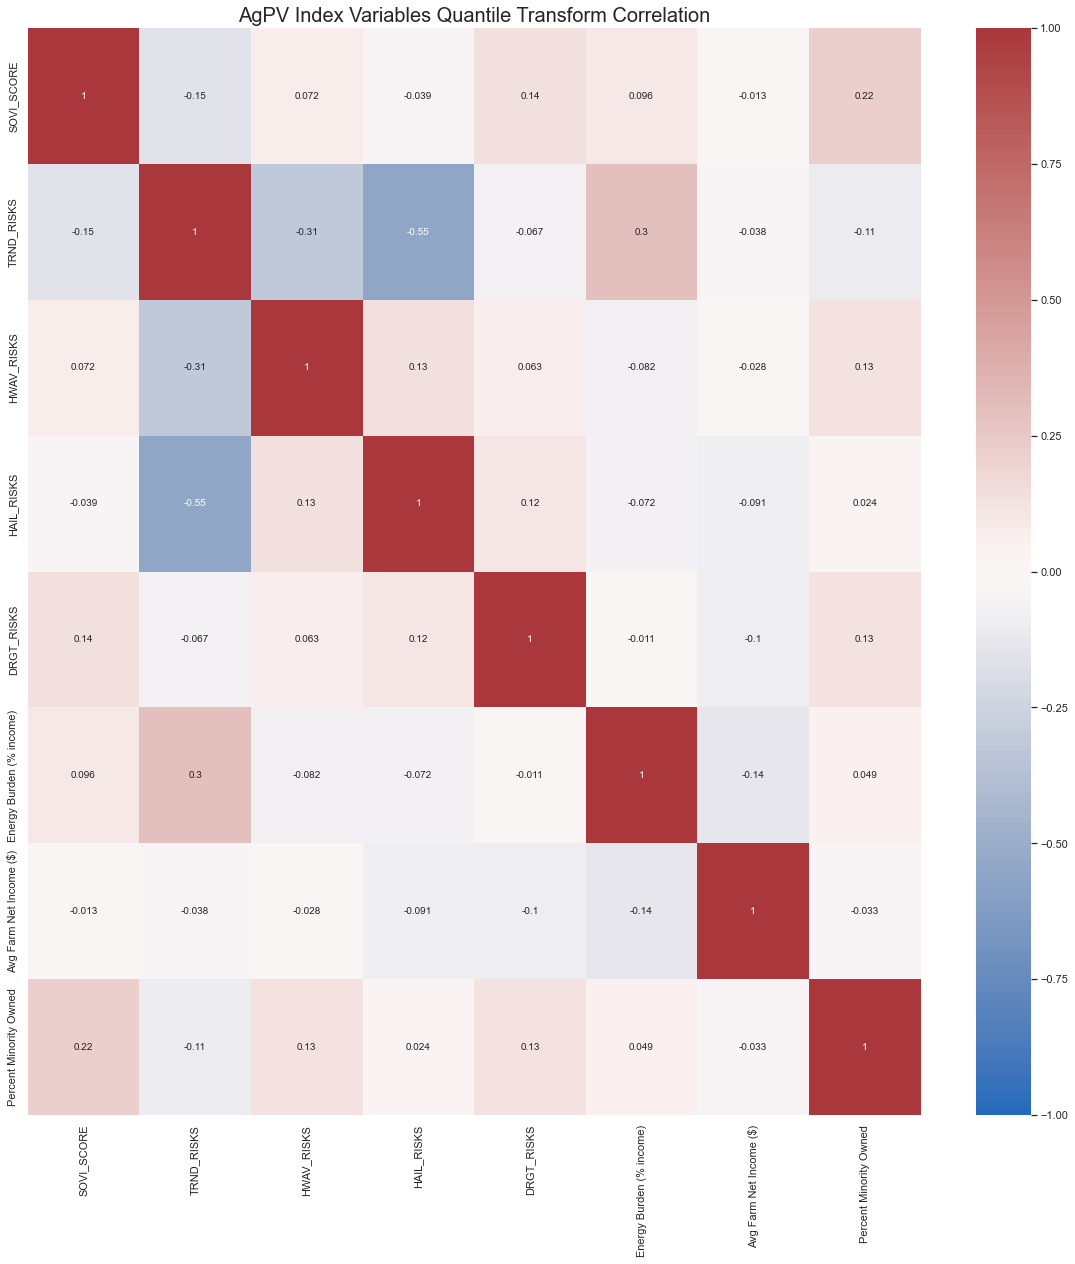

In [12]:
# correlation map with simplified variables and transformed
fig, ax = plt.subplots(figsize=(20,20))
corr_df = normalized_df.iloc[:, 2:].corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Quantile Transform Correlation', size=20)

In [13]:
# Get same columns from normalized df
plot_cols_df = merged_df[normalized_df.columns]
# scale un tranformed daata
scaled_original_data = scaler.fit_transform(plot_cols_df)
scaled_original_df = pd.DataFrame(scaled_original_data, index=plot_cols_df.index, columns=plot_cols_df.columns)
# add column to signify if this data has been quantile trandformed
scaled_original_df['Quantile Transform'] = 'No'
# join dfs
xform_comp_df = pd.concat([scaled_original_df, normalized_df])
xform_comp_df['Quantile Transform'] = xform_comp_df['Quantile Transform'].fillna('Yes')

Look at how wonderful these bell curves look!

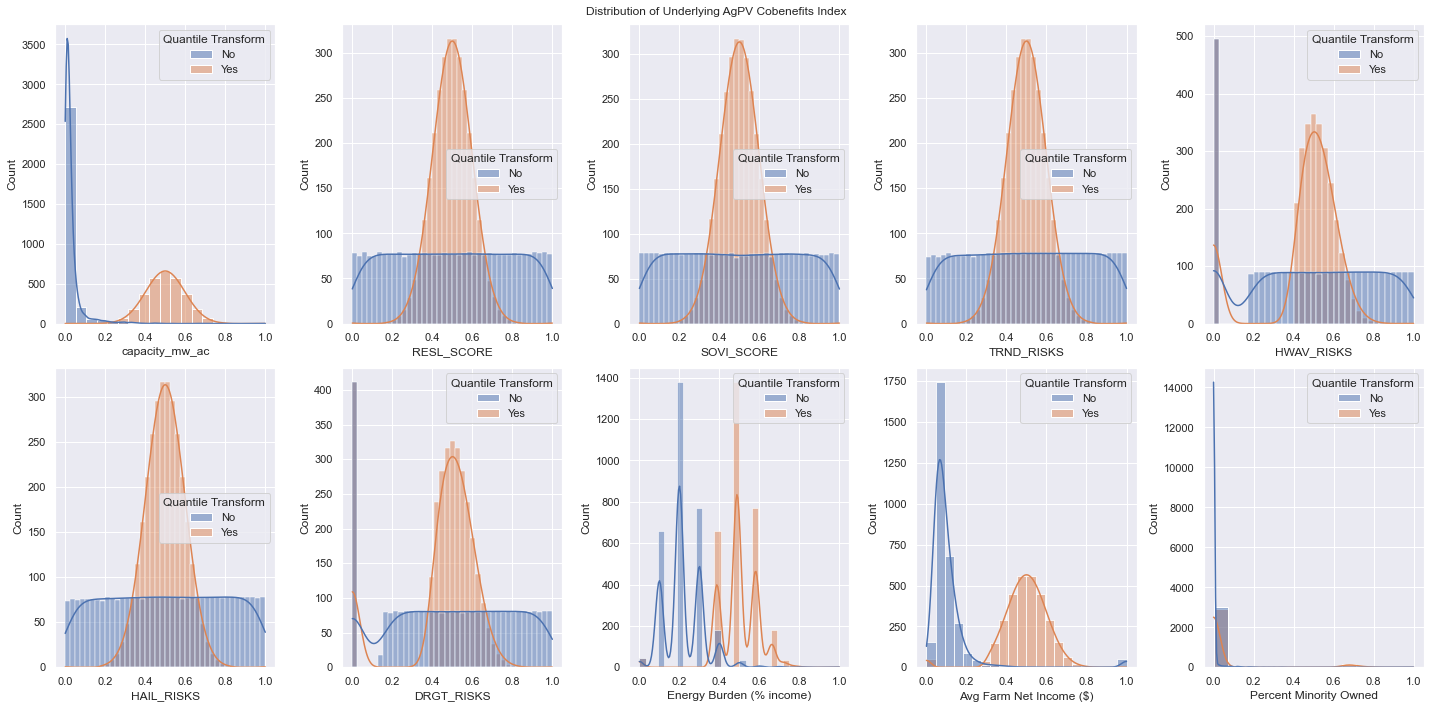

In [14]:
# look at histograms of transformed data compared to just minmax scaling. Look how beautiful these normal distributions are!
fig, axes = plt.subplots(2, 5, figsize=(20,10))

for col, ax in zip(xform_comp_df.iloc[:, :-1].columns, axes.flatten()):
    sns.histplot(xform_comp_df, x=col, kde=True, ax=ax, hue='Quantile Transform')
    
fig.suptitle('Distribution of Underlying AgPV Cobenefits Index')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_variable_distribution.png'))

### Ag PV Index Calculation

[Apache, AZ](https://en.wikipedia.org/wiki/Apache_County,_Arizona) stands out due to its near 100% minority cropland ownership, reasonably high energy burden (80th percentile), high drought risk (95th percentile), low torndo risk (2nd percentile), and high solar supply (99th percentile).

Most of this land is owned by the Navajo nation, so the high minoirty ownership is not suprising.

Also note that most of the top counties in overall index seem to have high social vulnerability as well. This makes sense, since climate hazards make up much of the underlying variables.


In [15]:
# get average of relevant variables
index_vars = ['capacity_mw_ac', 'TRND_RISKS', 'HWAV_RISKS', 'HAIL_RISKS', 'DRGT_RISKS', 'Energy Burden (% income)',
       'Avg Farm Net Income ($)', 'Percent Minority Owned']

# minmax scale final result
agpv_benefits_score = normalized_df[index_vars].mean(axis=1)
agpv_benefits_score = (agpv_benefits_score - agpv_benefits_score.min()) / (agpv_benefits_score.max() -agpv_benefits_score.min())

In [16]:
# merge calculated score with underlying data
score_df = pd.concat([merged_df, agpv_benefits_score], axis=1)
score_df = score_df.rename(columns={0:'AgPV_cobenefits_score'})

# filter relevant columns
score_df = score_df[plot_cols + ['AgPV_cobenefits_score']]
score_df = score_df.drop(columns=['capacity_mw_ac'])

# show top n counties
score_df.sort_values(['AgPV_cobenefits_score'], ascending=False).head(10)

county         state  capacity_mw_dc  RESL_SCORE  SOVI_SCORE  \
FIPS                                                                    
04001    Apache       Arizona   861473.520644    0.640000   96.500000   
46071   Jackson  South Dakota   151744.473926    0.380000   97.930000   
40135  Sequoyah      Oklahoma    26711.406422    7.100000   86.220001   
40107  Okfuskee      Oklahoma    29631.438316    9.930000   86.599998   
06107    Tulare    California    38451.738669   12.830000   93.440002   
48029     Bexar         Texas    37654.127497   38.639999   92.489998   
46121      Todd  South Dakota   119771.505357    0.190000   96.279999   
41045   Malheur        Oregon   332408.348564    6.080000   99.430000   
51083   Halifax      Virginia    43117.128771   33.669998   70.150002   
06047    Merced    California    64317.236668   15.470000   96.980003   

       TRND_RISKS  HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  \
FIPS                                                    
04001    3.372574   17.817372    1.336303   95.259306   
46071   16.671969   40.152720   59.115495   34.139357   
40135   82.278078   96.531976   49.156857   86.859688   
40107   41.552657   89.818645   70.601336   60.610881   
06107   33.439389   99.650016   88.514158   98.218263   
48029   99.872733   97.804645   99.681833   88.927776   
46121   41.170856   61.565383   70.124085   29.971365   
41045   10.881324   81.355393   55.488387   70.855870   
51083   28.125994   38.752784   57.461024   76.201082   
06047   28.635062   99.013681   55.329303   99.045498   

       Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                       
04001                       4.0                  -4575.0   
46071                       9.0                  56834.0   
40135                       4.0                   6279.0   
40107                       4.0                  -5160.0   
06107                       3.0                 215616.0   
48029                       2.0                  -5431.0   
46121                       8.0                  54643.0   
41045                       3.0                  56988.0   
51083                       5.0                   2959.0   
06047                       3.0                 237457.0   

       Percent Minority Owned  Negative Net Farm Income  AgPV_cobenefits_score  
FIPS                                                                            
04001               98.988622                         1               1.000000  
46071               13.211452                         0               0.912968  
40135               47.188558                         0               0.902996  
40107                0.641849                         1               0.900074  
06107                0.124708                         0               0.899646  
48029               14.724204                         1               0.893510  
46121                5.786618                         0               0.893184  
41045                6.214844                         0               0.891014  
51083                3.561254                         0               0.889283  
06047                1.604239                         0               0.887463

In [17]:
score_df.sort_values(['AgPV_cobenefits_score'], ascending=False).rank(pct=True).head()

county     state  capacity_mw_dc  RESL_SCORE  SOVI_SCORE  TRND_RISKS  \
FIPS                                                                            
04001  0.022713  0.024335        0.999676    0.006814    0.964958    0.024010   
46071  0.437216  0.764925        0.957171    0.004218    0.979559    0.156067   
40135  0.818624  0.691759        0.648605    0.071382    0.863076    0.819598   
40107  0.674886  0.691759        0.686243    0.098962    0.866321    0.404932   
06107  0.901687  0.060513        0.773848    0.127515    0.934783    0.322842   

       HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  Energy Burden (% income)  \
FIPS                                                                  
04001    0.167748    0.004543    0.951655                  0.799643   
46071    0.393251    0.584361    0.329981                  0.999513   
40135    0.964958    0.483128    0.865996                  0.799643   
40107    0.896496    0.700519    0.598313                  0.799643   
06107    0.996431    0.883193    0.981830                  0.451493   

       Avg Farm Net Income ($)  Percent Minority Owned  \
FIPS                                                     
04001                 0.059377                1.000000   
46071                 0.683971                0.992862   
40135                 0.249189                0.999676   
40107                 0.050941                0.951979   
06107                 0.961389                0.944517   

       Negative Net Farm Income  AgPV_cobenefits_score  
FIPS                                                    
04001                  0.928942               1.000000  
46071                  0.428942               0.999676  
40135                  0.428942               0.999351  
40107                  0.928942               0.999027  
06107                  0.428942               0.998702

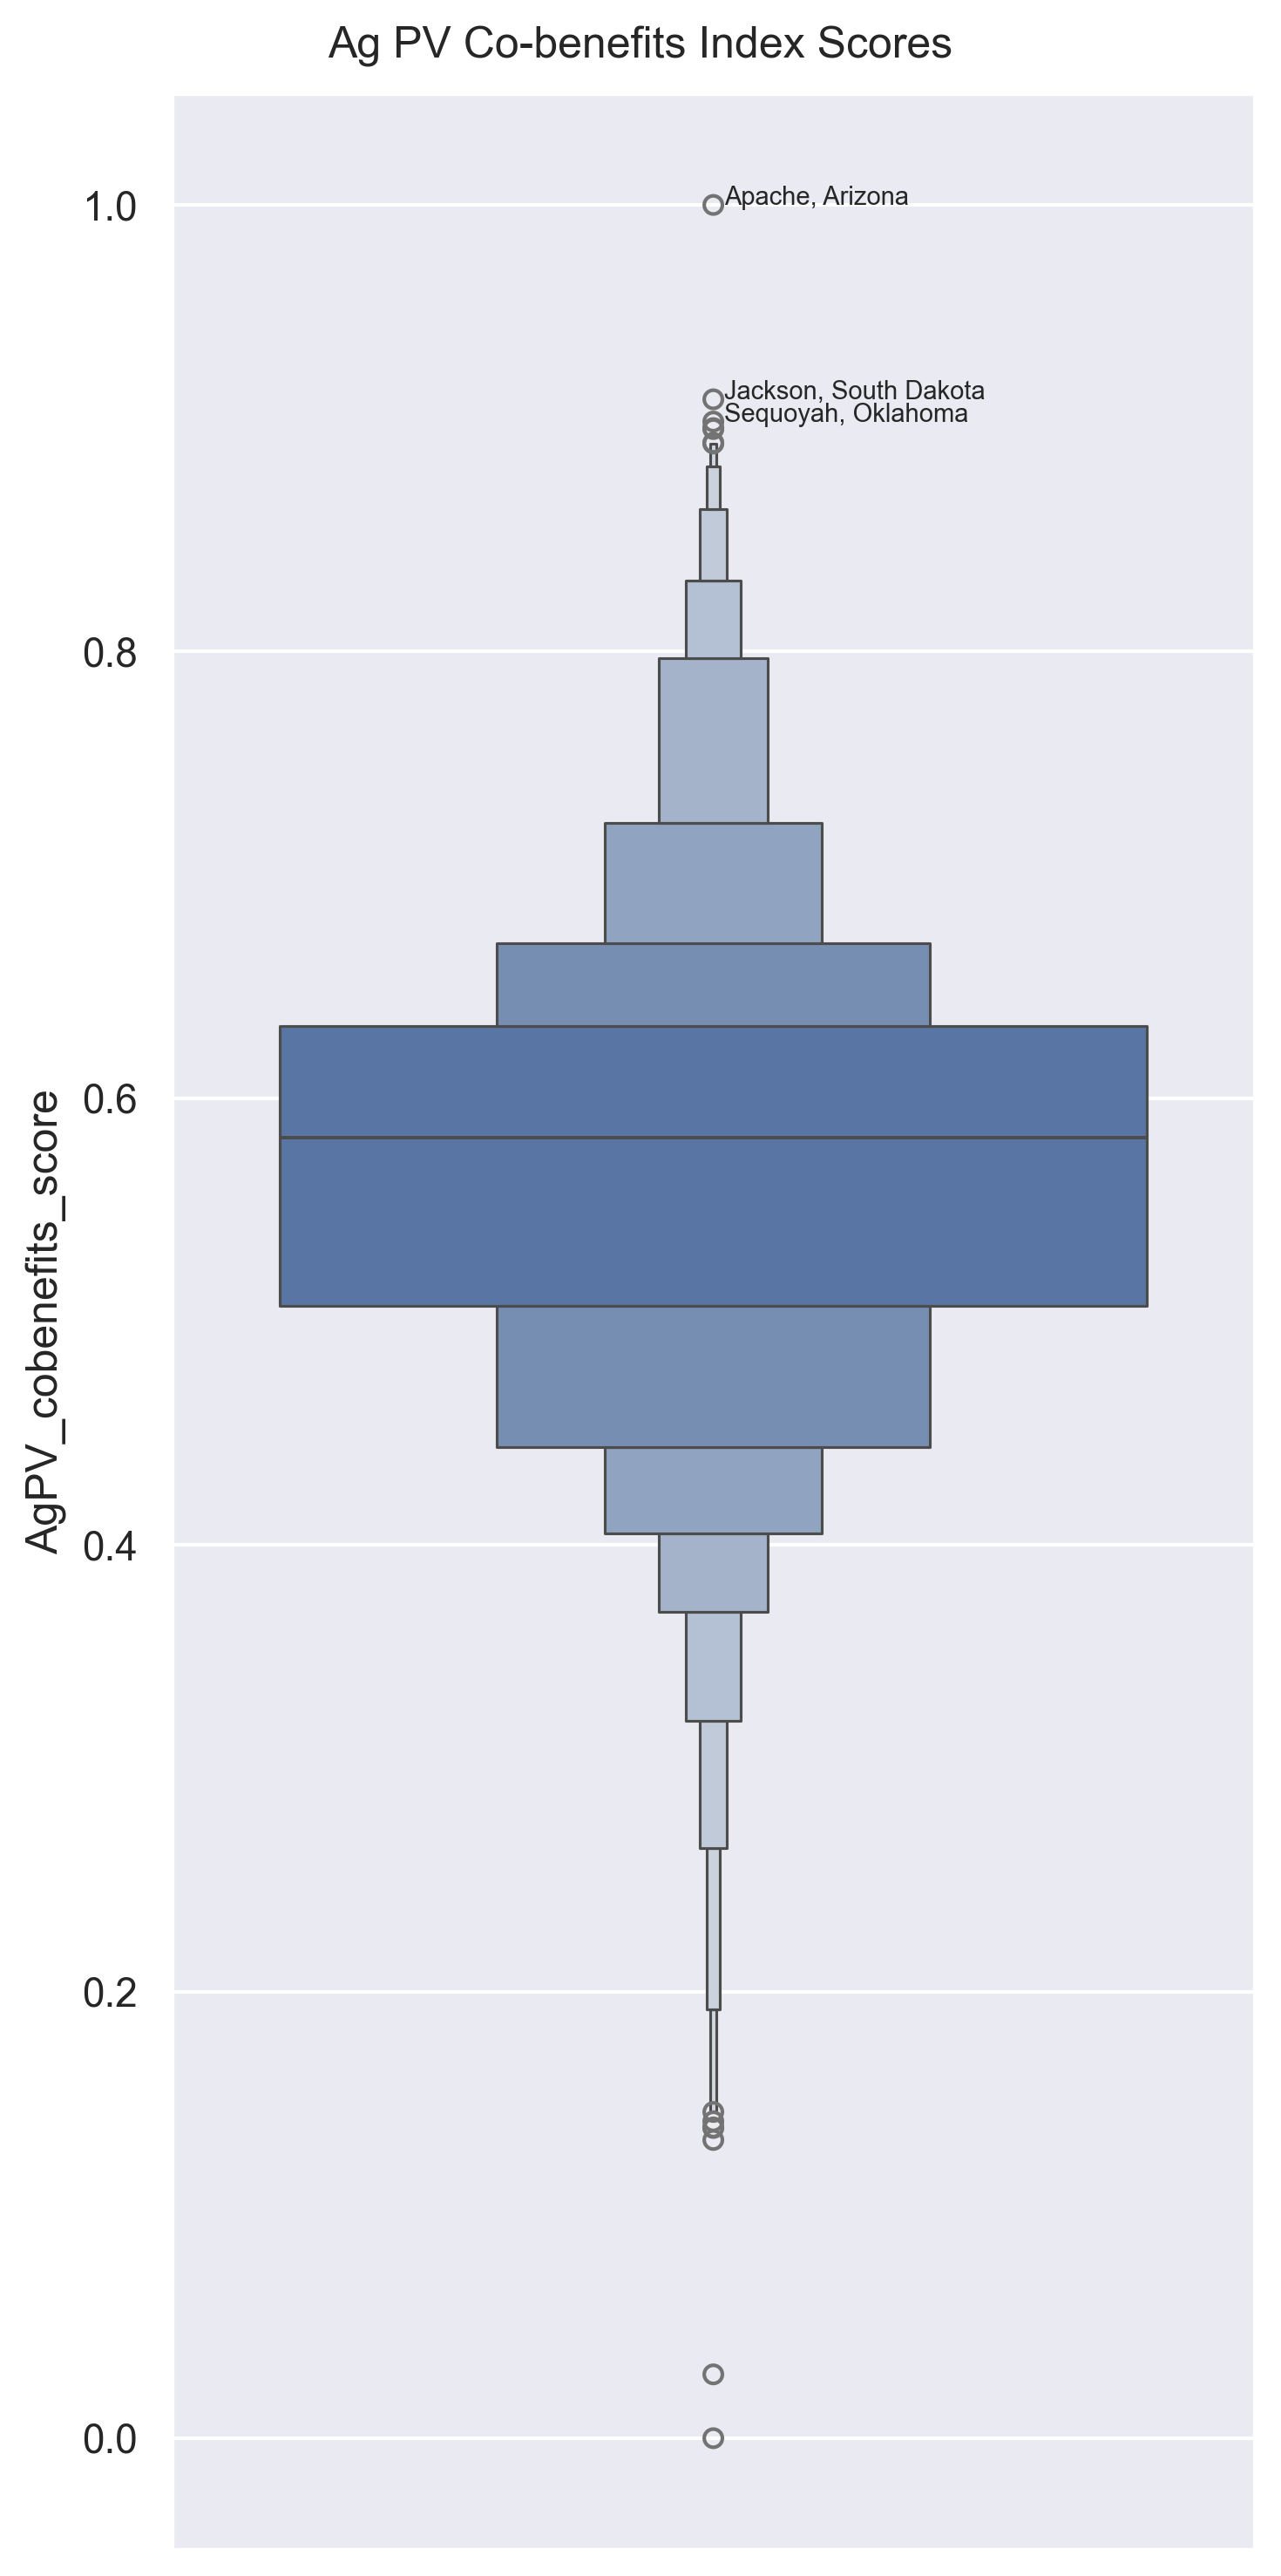

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,10), dpi=300)
g = sns.boxenplot(score_df, y='AgPV_cobenefits_score')

# annotate top n outliers
def annotate_outliers(row, g):
    text = ', '.join([row['county'], row['state']])
    y = row['AgPV_cobenefits_score']
    g.annotate(text, xy=(0.01, y), ha='left', size=7)
    
score_df.sort_values('AgPV_cobenefits_score', ascending=False).iloc[:3].apply(lambda x: annotate_outliers(x, g), axis=1)

fig.suptitle('Ag PV Co-benefits Index Scores')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_score_boxen.png'))

## Clustering
Let's do some simple unsupervised learning on this data set. Maybe using clusters can provide more nuaced themes and analysis for groups that a single number might overlook.

This [post](https://medium.com/@jackiee.jecksom/clustering-and-principal-component-analysis-pca-from-sklearn-c8ea5fed6648) has some cool visualization ideas: 

<Axes: >

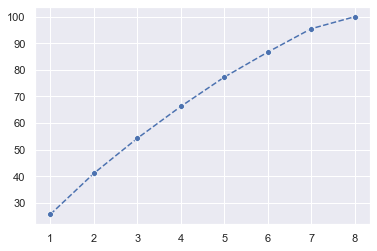

In [40]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# normalize data
X_norm = StandardScaler().fit_transform(merged_df[index_vars])

# principal component analysis
pca = PCA()
pca.fit(X_norm)
# get percent variance explained
percent_var = np.round(pca.explained_variance_ratio_ * 100, 3)

sns.lineplot(x=range(1, len(percent_var) + 1), y=percent_var.cumsum(), marker='o', linestyle='--')

Without quantile normaization, 6 principle components explain ~85% of the variance. This seems like a good number to choose.

In [52]:
n_comps=6
pca = PCA(n_components=n_comps)
pca.fit(X_norm)
scores_pca = pca.transform(X_norm)

k_values = range(2,21)
# clustering
WCSS = [] # holds within cluster sum of squares for eack value of k

for k in k_values:
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
    kmeans_pca.fit(scores_pca)
    WCSS.append(kmeans_pca.inertia_)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

Text(0, 0.5, 'WCSS')

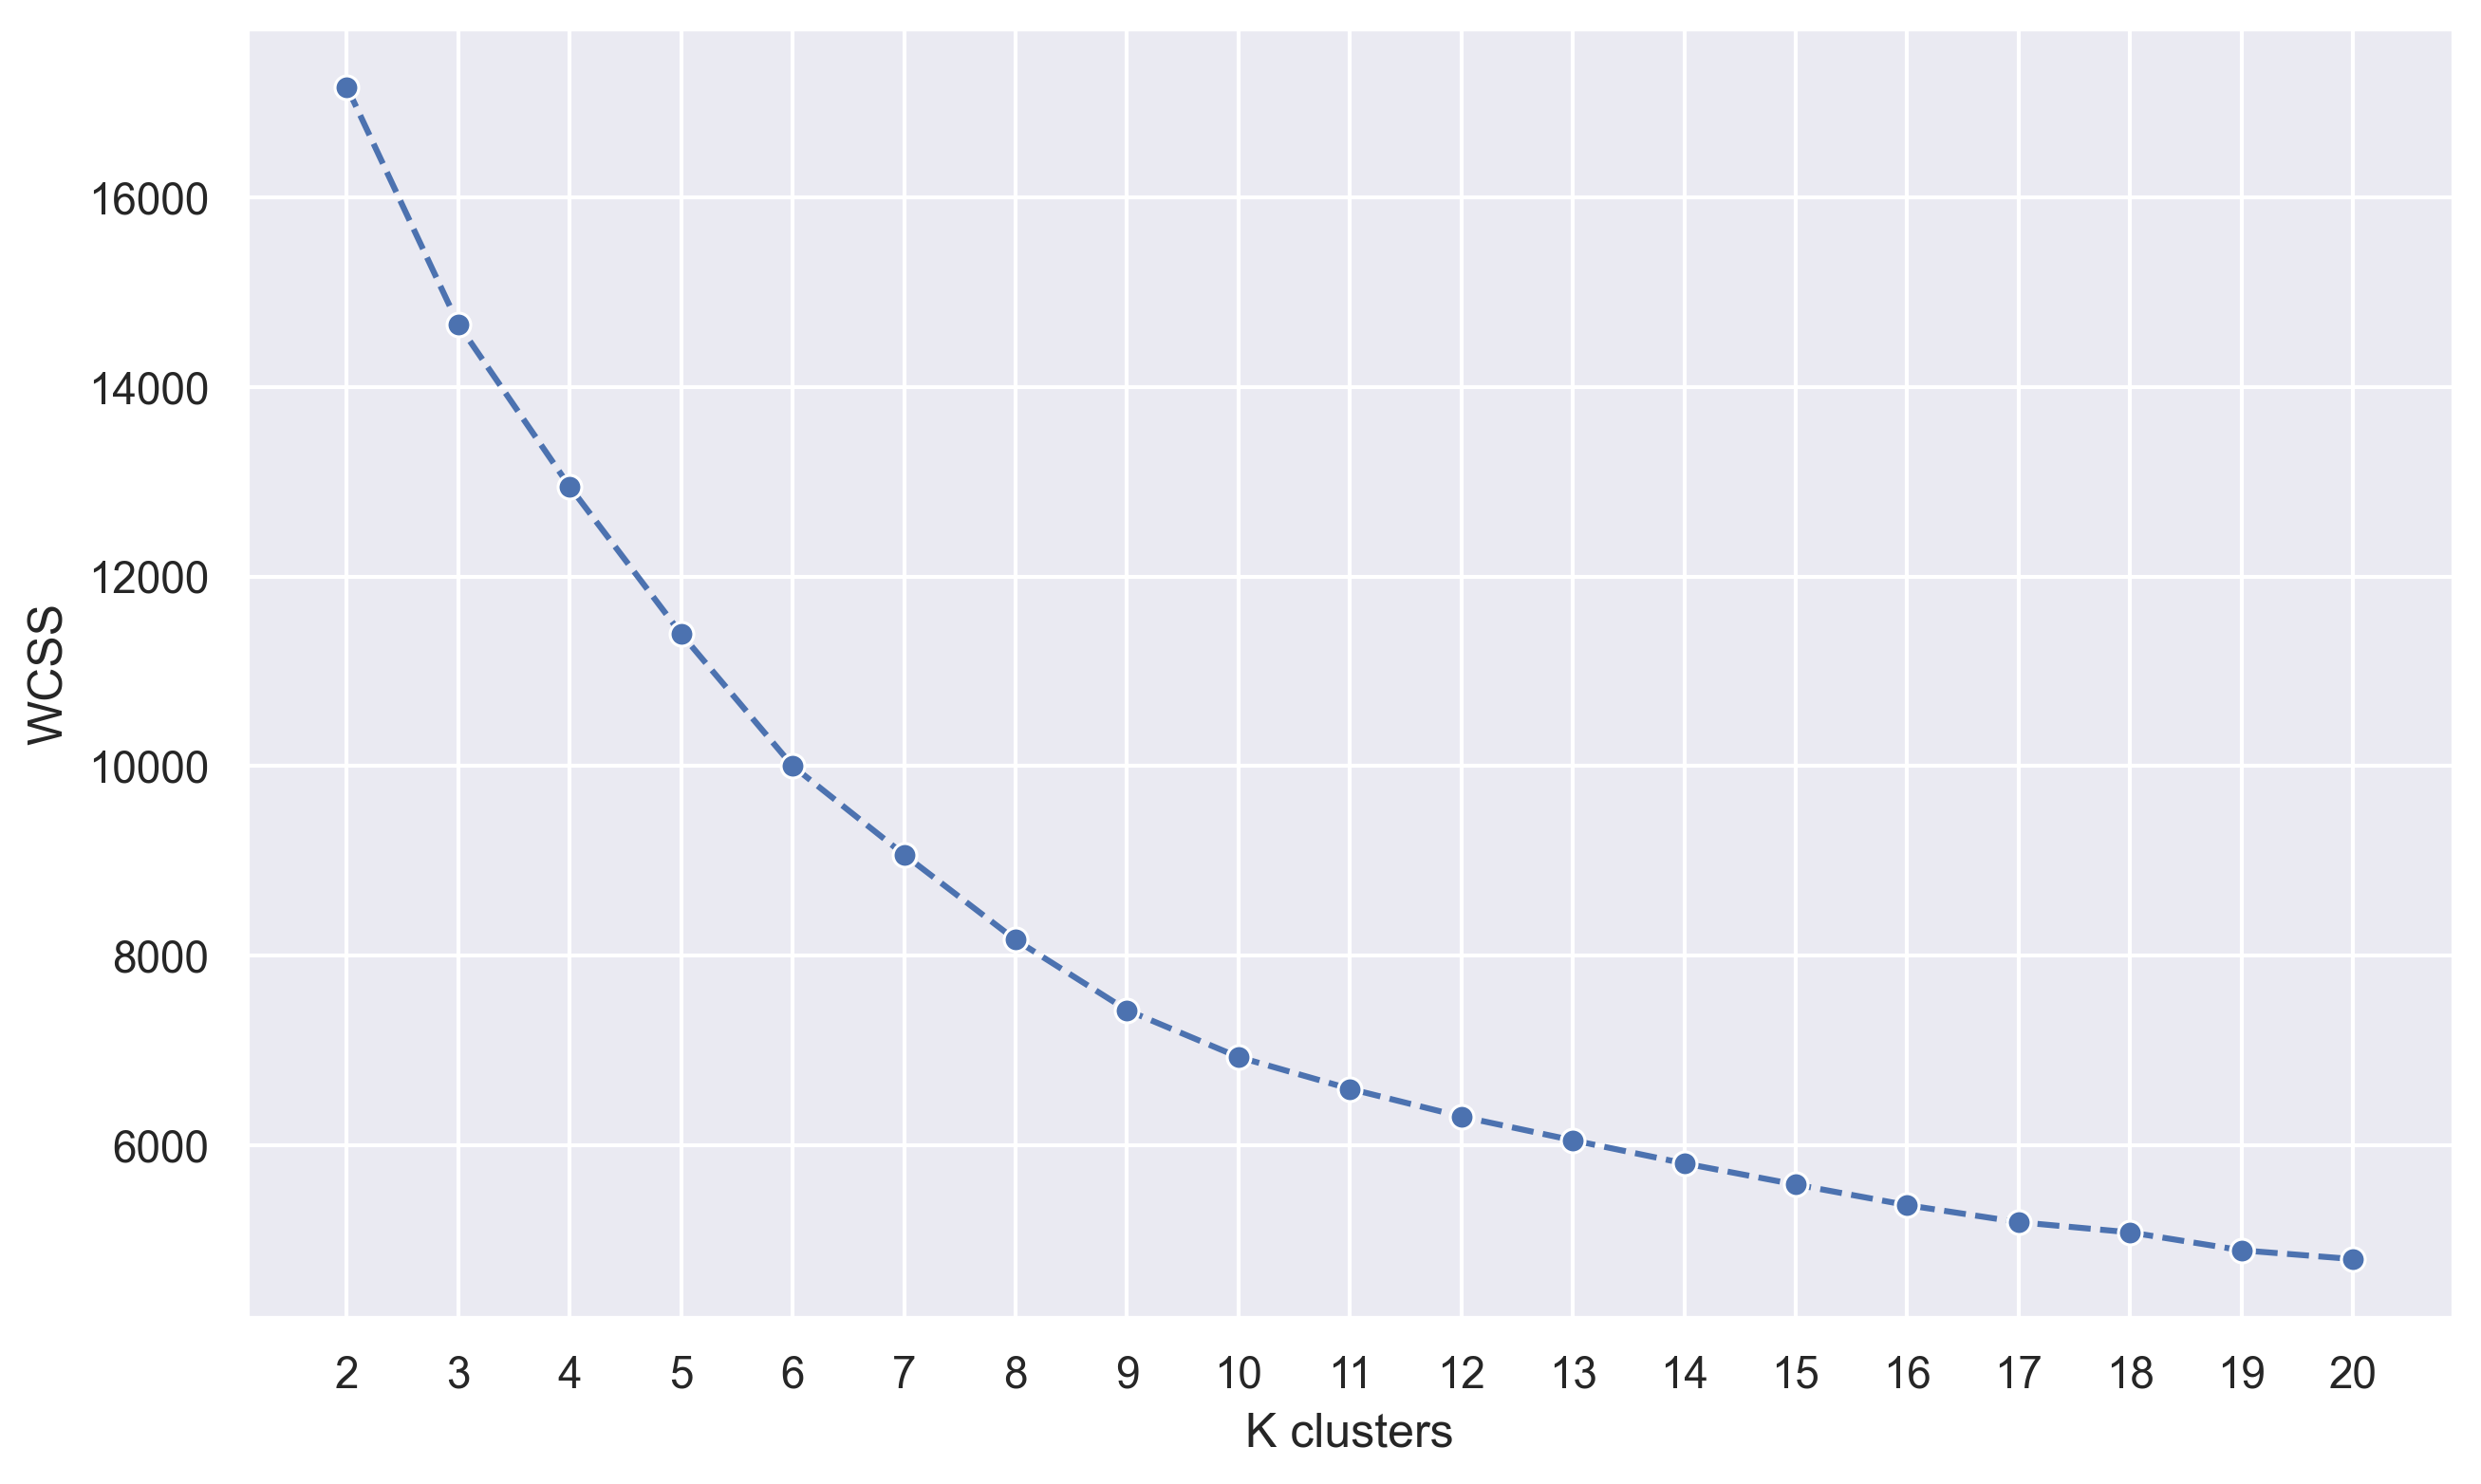

In [53]:
plt.figure(figsize=(10,6), dpi=300)
g = sns.lineplot(x=k_values, y=WCSS, marker='o', linestyle='--')
g.set_xticks(k_values)
g.set_xlabel('K clusters')
g.set_ylabel('WCSS')

There's no clear elbow point. K=8 or 9 seems like there's a slight change in slope of the line. Using silhoutte score might give more detail. Let's use 8 for now.

In [54]:
k = 8
kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
kmeans_pca.fit(scores_pca)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(random_state=123)

In [55]:
# Add pricipal components to original df
pc_col_names = ['PC' + str(k + 1) for k in range(n_comps)]
cluster_df = pd.concat([merged_df[index_vars], pd.DataFrame(scores_pca, columns=pc_col_names, index=merged_df.index)], axis=1)

# add labels from kmeans
cluster_df['Cluster'] = kmeans_pca.labels_
cluster_df['Cluster'] = cluster_df['Cluster'].astype(str)
cluster_df

capacity_mw_ac  TRND_RISKS  HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  \
FIPS                                                                    
01001    22349.202978   73.846643   87.082405   57.111040   50.652243   
01003    46948.973155   91.377665   91.091314   52.943048   86.796055   
01005    43344.657028   73.942094   69.710468   39.993637   80.687241   
01007    28368.690972   71.969456   67.228762   43.684378   32.421254   
01009    18483.385380   89.723194   82.437162   43.716195   52.147630   
...               ...         ...         ...         ...         ...   
56037   401041.398994   10.531339    0.000000    3.340757   29.812281   
56039     4915.661374   21.189946    0.000000   39.102768   21.539930   
56041    83816.558073   12.567611    0.000000   17.817372   25.676106   
56043    72277.627225   13.013045    0.000000    5.058861   43.143493   
56045   155044.608219   24.657970    0.000000   76.073815   19.153675   

       Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                       
01001                       3.0                  18279.0   
01003                       2.0                  35436.0   
01005                       4.0                  63011.0   
01007                       4.0                  -1650.0   
01009                       3.0                  66897.0   
...                         ...                      ...   
56037                       2.0                  21628.0   
56039                       2.0                   6411.0   
56041                       3.0                  10310.0   
56043                       4.0                  28058.0   
56045                       7.0                  15943.0   

       Percent Minority Owned       PC1       PC2       PC3       PC4  \
FIPS                                                                    
01001                     0.0 -1.263964  0.056961  0.446473 -0.021109   
01003                     0.0 -2.020643  0.748197  0.722191  0.201325   
01005                     0.0 -0.465452  0.871521 -0.317149 -0.321611   
01007                     0.0 -0.251004 -0.139357  0.297733 -0.285738   
01009                     0.0 -1.351565 -0.050923  0.343780  0.325691   
...                       ...       ...       ...       ...       ...   
56037                     0.0  4.239126  2.653782  2.739089  0.896666   
56039                     0.0  1.221499 -1.309285  0.760865  0.098704   
56041                     0.0  2.486776 -0.315688  0.818262  0.056125   
56043                     0.0  2.828408  0.047196  0.210767 -0.222194   
56045                     0.0  3.047047  1.350500 -1.423704 -1.901273   

            PC5       PC6 Cluster  
FIPS                               
01001  0.088991 -0.252415       6  
01003 -1.168157 -0.479737       6  
01005 -0.132648 -0.801501       5  
01007  0.800031 -0.111082       5  
01009  0.047799 -0.429856       6  
...         ...       ...     ...  
56037 -3.820970  3.548544       4  
56039 -0.265153  0.541744       0  
56041 -0.529480  0.632433       0  
56043 -0.209691 -0.158202       0  
56045  1.345592  2.126461       1  

[3082 rows x 15 columns]

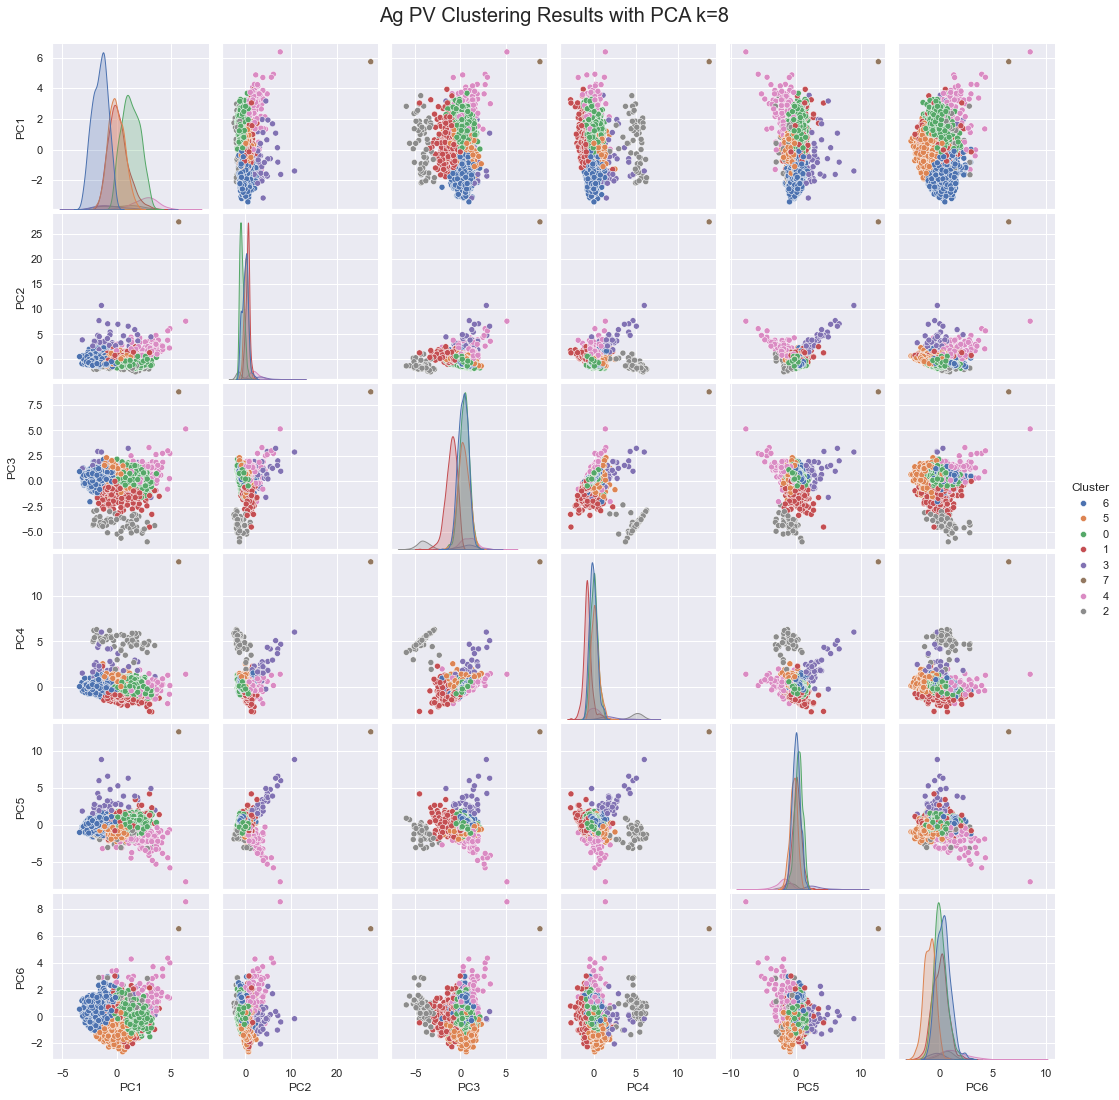

In [71]:
sns.pairplot(cluster_df.iloc[:,-n_comps-1:], hue='Cluster')
plt.suptitle('Ag PV Clustering Results with PCA k=8', size=20, y=1.02)
plt.savefig(os.path.join(graph_dir, 'agpv_pca_clustering.png'))

## Clustering Analysis
Most of the results seem jumbled together, but there's a few groups that stand out.

* Cluster 2 has clear separation in a few of the views.
* Cluster 4 also gets some separation
* Cluster 7 only has 1 point, but it is a clear outlier from everything else. I bet this is Apache, AZ
* The purple cluster (cluster 3) seems to be closer to cluster 7 than the other clusters

Let's have a look at the clusters:

In [67]:
cluster_summary = cluster_df.groupby(['Cluster']).mean().round(2)
# drop pc values
cluster_summary = cluster_summary.loc[:, :'Percent Minority Owned']
cluster_summary

capacity_mw_ac  TRND_RISKS  HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  \
Cluster                                                                   
0              20948.68       29.27       27.08       30.19       21.01   
1              23573.55       45.71       36.26       70.49       69.86   
2              16339.48       44.07       44.14       40.17       24.39   
3              28635.92       62.10       72.03       48.65       68.00   
4             233861.88       14.58       30.13       26.53       61.93   
5              19520.99       47.86       62.51       29.67       66.85   
6              16671.52       80.31       70.85       73.52       48.11   
7             642890.58        3.37       17.82        1.34       95.26   

         Energy Burden (% income)  Avg Farm Net Income ($)  \
Cluster                                                      
0                            3.35                 25003.58   
1                            4.04                 84669.06   
2                            2.75               1016329.11   
3                            3.74                 54546.63   
4                            3.31                 42215.05   
5                            2.91                 48575.67   
6                            2.59                 34691.85   
7                            4.00                 -4575.00   

         Percent Minority Owned  
Cluster                          
0                          0.01  
1                          0.10  
2                          0.00  
3                         16.61  
4                          0.18  
5                          0.13  
6                          0.20  
7                         98.99

Cluster 7 is Apache AZ. High minority cropland ownership!

Cluster 4 is defined by it's high solar potential
Cluster 2 has high Avg Farm Net income
Cluster 6: high tornado risk

In [73]:
score_df.to_csv('agpv_cobenefits_index.csv')